<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd               # データを表のように扱うライブラリ
import numpy as np                # 数値計算を速くするライブラリ
import seaborn as sns             # きれいなグラフを簡単に作るライブラリ
import matplotlib.pyplot as plt   # グラフを作る基本的なライブラリ
%matplotlib inline

from sklearn.model_selection import train_test_split  # データを訓練用と検証用に分ける
from sklearn.metrics import mean_squared_log_error # 評価の計算を行うライブラリ
import lightgbm as lgb # 予測モデルに関するライブラリ

import warnings
warnings.simplefilter('ignore')  # 不要な警告を表示しない

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [50]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df


def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみスキューネスとカートシスを計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

# yeojohnson変換
def yeojohnson_transform(df, col):
    from scipy.stats import yeojohnson

    # 欠損値を一時的に削除してYeo-Johnson変換を適用
    transformed_values, lamda_y = yeojohnson(df[col].dropna())

    # 変換された値を元のインデックスに戻し、欠損値の位置にはNaNを入れる
    df[col + "_yeojohnson"] = pd.Series(transformed_values, index=df[col].dropna().index)

    print("lamda_y:", lamda_y)
    return

# データの読み込み

In [51]:
# 予測モデルを訓練するためのデータセット
train = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv', index_col=0)

# 予測モデルに推論（予測)させるデータセット
test = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv', index_col=0)

In [52]:
information_df(train)

(4655, 21)


,dtypes,NaN Count,Nunique,Unique Values
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."
PrimaryNAICS,int64,0,227,"[326121, 486210, 211112, 221112, 213112, 32212..."


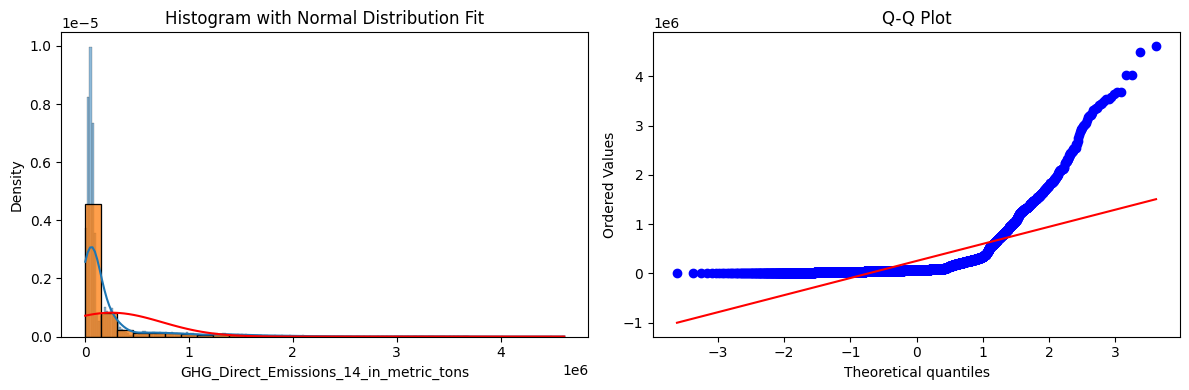

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [53]:
normal_distribution_fit(train, 'GHG_Direct_Emissions_14_in_metric_tons')

In [54]:
train['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train['GHG_Direct_Emissions_14_in_metric_tons'])

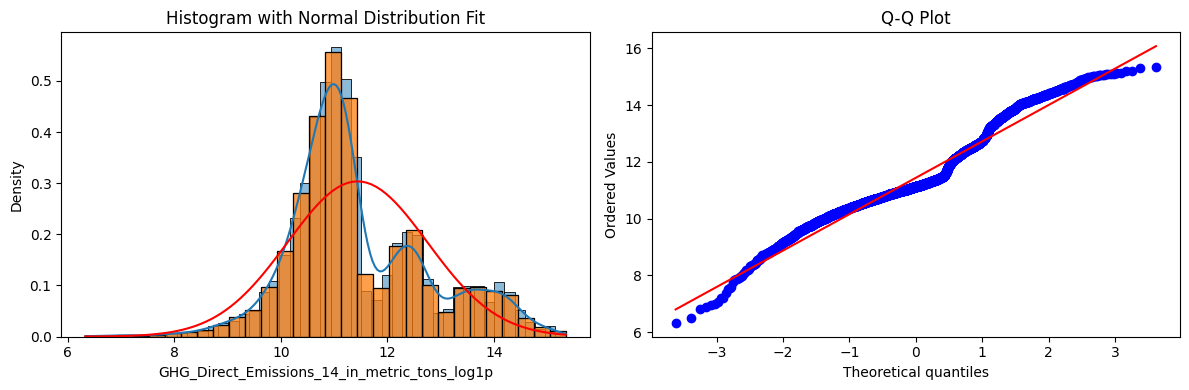

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0


In [55]:
normal_distribution_fit(train, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [56]:
information_df(test)

(2508, 20)


,dtypes,NaN Count,Nunique,Unique Values
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."
PrimaryNAICS,int64,0,185,"[211112, 486210, 327213, 322130, 333611, 22111..."


In [57]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_test["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train, test)

In [58]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

In [59]:
information_df(df)

(7163, 23)


,dtypes,NaN Count,Nunique,Unique Values
FacilityName,category,0,6904,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,158,6895,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,158,6884,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,category,292,6796,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,category,0,3381,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,category,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,category,0,5377,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,category,115,1309,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,118,1924,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."
PrimaryNAICS,int64,0,257,"[326121, 486210, 211112, 221112, 213112, 32212..."


# 特徴量エンジニアリング  


#### 場所を表す特徴量

In [60]:
# missing_location = df[df['Latitude'].isnull() | df['Longitude'].isnull()]

In [61]:

# # 各州の地理的な中心位置の緯度と経度
# state_coordinates = {
#     'LA': (30.9843, -91.9623),
#     'PA': (40.2737, -76.8844),
#     'MS': (32.7416, -89.6787),
#     'TX': (31.9686, -99.9018),
#     'KY': (37.8393, -84.2700),
#     'SD': (44.2998, -99.4388),
#     'VA': (37.4316, -78.6569),
#     'WY': (43.0759, -107.2903),
#     'UT': (40.1500, -111.8624),
#     'OK': (35.4676, -97.5164),
#     'WV': (38.5976, -80.4549),
#     'AK': (61.3707, -149.4937),
#     'OH': (40.4173, -82.9071),
#     'GA': (33.8361, -84.5037),
#     'NM': (34.5199, -105.8701),
#     'CO': (39.5501, -105.7821),
#     'AL': (32.8067, -86.7911),
#     'AZ': (34.0489, -111.0937),
#     'KS': (38.5266, -96.7265),
#     'CA': (36.7783, -119.4179)
# }

# # 各州の緯度・経度を対応する行に更新
# for index, row in missing_location.iterrows():
#     state = row['State']
#     if state in state_coordinates:
#         missing_location.loc[index, 'Latitude'], missing_location.loc[index, 'Longitude'] = state_coordinates[state]

# print(missing_location['Latitude'].isnull().sum())
# print(missing_location['Longitude'].isnull().sum())

In [62]:
# df.loc[missing_location.index, 'Latitude'] = missing_location['Latitude']
# df.loc[missing_location.index, 'Longitude'] = missing_location['Longitude']

In [63]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


*   データは2014年だけなので、他の年も確認すると良いかもしれない。
*   観測点の位置や周辺に何があるかを判定できるデータがあると良いかもしれない。工業地帯や移住区か商業区かなど。
*   アメリカは広大で西海岸、東海岸、アラスカ、離島など差がある場合はより強調させる特徴量が必要になるかも。


In [64]:
location_features = ['Latitude', 'Longitude']

#### 業種を表す特徴量

In [65]:
# 'IndustryType'の欠損値を'Other'で埋める
df['IndustryType'] = df['IndustryType'].fillna('Other')

# 'IndustryType'をカンマで分割し、リストにする
df['IndustryType'] = df['IndustryType'].str.split(',')

# 分割した後、余分な空白を削除する
df['IndustryType'] = df['IndustryType'].apply(lambda x: [i.strip() for i in x])

# ワンホットエンコーディング
df_encoded = df['IndustryType'].explode().str.get_dummies()

# 行方向に集約 (同じ業種に対して1を設定)
df_encoded = df_encoded.groupby(df_encoded.index).sum()

# オリジナルのDataFrameと結合
df = pd.concat([df, df_encoded], axis=1)

In [66]:
df.columns

Index(['FacilityName', 'Latitude', 'Longitude', 'LocationAddress', 'City',
       'State', 'ZIP', 'County', 'FIPScode', 'PrimaryNAICS',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons_log1p', 'is_train', 'Chemicals',
       'Coal-based Liquid Fuel Supply',
       'Import and Export of Equipment Containing Fluorintaed GHGs',
       'Industrial Gas Suppliers', 'Injection of CO2', 'Metals', 'Minerals',
       'Natural Gas and Natural Gas Liquids Suppliers', 'Other',
       'Petroleum Product Suppliers', 'Petroleum and Natural Gas Systems',
       'Power Plants', 'Pulp and Pape

In [67]:
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)
df['PrimaryNAICS_1-5'] = df['PrimaryNAICS'].astype(str).str[:5].astype(int)

df.head()

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,is_train,Chemicals,Coal-based Liquid Fuel Supply,Import and Export of Equipment Containing Fluorintaed GHGs,Industrial Gas Suppliers,Injection of CO2,Metals,Minerals,Natural Gas and Natural Gas Liquids Suppliers,Other,Petroleum Product Suppliers,Petroleum and Natural Gas Systems,Power Plants,Pulp and Paper,Refineries,Suppliers of CO2,Waste,PrimaryNAICS_1-2,PrimaryNAICS_1-3,PrimaryNAICS_1-4,PrimaryNAICS_1-5
0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,NaN,[Other],31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946,10.877559,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,32,326,3261,32612
1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,NaN,[Petroleum and Natural Gas Systems],NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617,10.931518,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,48,486,4862,48621
2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,NaN,[Petroleum and Natural Gas Systems],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214,10.927386,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,21,211,2111,21111
3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,NaN,[Power Plants],NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782,11.025375,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22,221,2211,22111
4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,NaN,[Power Plants],29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774,10.671312,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22,221,2211,22111


In [68]:
naics_groups = {
    '01': '農業、林業、漁業、狩猟',
    '21': '鉱業、採石業、石油・ガス採掘',
    '22': 'ユーティリティ',
    '23': '工事',
    '31': '製造業',
    '32': '製造業',
    '33': '製造業',
    '41': '卸売業',
    '42': '卸売業',
    '44': '小売業',
    '45': '小売業',
    '48': '輸送および倉庫',
    '49': '輸送および倉庫',
    '51': '情報',
    '52': '金融と保険',
    '53': '不動産・賃貸・リース',
    '54': '専門的、科学的、技術的サービス',
    '55': '企業経営',
    '56': '管理およびサポート、廃棄物管理および修復サービス',
    '61': '教育サービス',
    '62': '医療と社会扶助',
    '71': '芸術、娯楽、レクリエーション',
    '72': '宿泊・飲食サービス',
    '81': 'その他のサービス（行政を除く）',
    '91': '行政',
    '92': '行政'
}

df['IndustryGroup_str'] = df['PrimaryNAICS_1-2'].apply(lambda x: naics_groups.get(x))
df.head()

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,is_train,Chemicals,Coal-based Liquid Fuel Supply,Import and Export of Equipment Containing Fluorintaed GHGs,Industrial Gas Suppliers,Injection of CO2,Metals,Minerals,Natural Gas and Natural Gas Liquids Suppliers,Other,Petroleum Product Suppliers,Petroleum and Natural Gas Systems,Power Plants,Pulp and Paper,Refineries,Suppliers of CO2,Waste,PrimaryNAICS_1-2,PrimaryNAICS_1-3,PrimaryNAICS_1-4,PrimaryNAICS_1-5,IndustryGroup_str
0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,NaN,[Other],31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946,10.877559,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,32,326,3261,32612,None
1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,NaN,[Petroleum and Natural Gas Systems],NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617,10.931518,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,48,486,4862,48621,None
2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,NaN,[Petroleum and Natural Gas Systems],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214,10.927386,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,21,211,2111,21111,None
3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,NaN,[Power Plants],NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782,11.025375,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22,221,2211,22111,None
4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,NaN,[Power Plants],29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774,10.671312,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22,221,2211,22111,None


In [69]:
industry_feature = ['Chemicals',
       'Coal-based Liquid Fuel Supply',
       'Import and Export of Equipment Containing Fluorintaed GHGs',
       'Industrial Gas Suppliers', 'Injection of CO2', 'Metals', 'Minerals',
       'Natural Gas and Natural Gas Liquids Suppliers', 'Other',
       'Petroleum Product Suppliers', 'Petroleum and Natural Gas Systems',
       'Power Plants', 'Pulp and Paper', 'Refineries', 'Suppliers of CO2',
       'Waste',
                    # 'PrimaryNAICS_1-2',
                    'PrimaryNAICS_1-3', 'PrimaryNAICS_1-4','PrimaryNAICS_1-5']

## TRI_emissions

In [70]:
numerical_features = [
    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
    ]

# num_bins = 100
# min_value = df[numerical_features].min().min()
# max_value = df[numerical_features].max().max()
# bins = np.linspace(min_value, max_value, num_bins)

# for col in numerical_features:
#     plt.figure(figsize=(12, 3))
#     sns.histplot(df[col], bins=bins, kde=True)
#     plt.title(f'{col}の分布')
#     plt.xlabel(col)
#     plt.ylabel('頻度')
#     plt.show()
#     print()



*   TRIの2014年のものがないので、TRIも予測すると良いかも。
*   一番低い度数に偏っているので、分布の補正をかけると良いかもしれない。



lamda_y: -0.5119838730961517


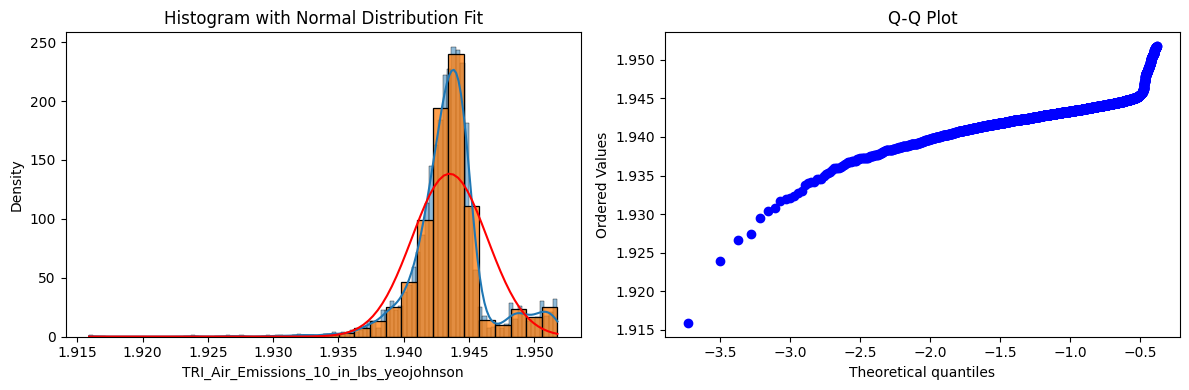

Skewness: -0.42300754162989024
Kurtosis: 6.862268864375837
isnull: 4654

lamda_y: -0.09218724774374076


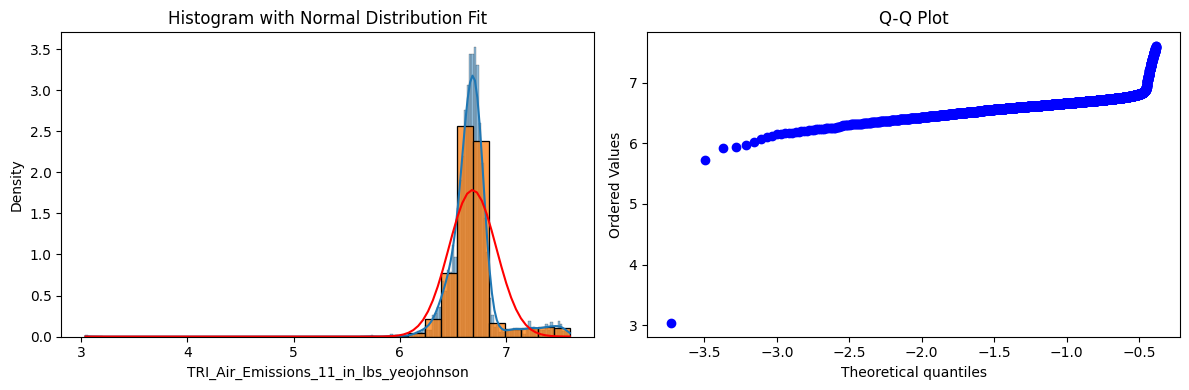

Skewness: -0.4304409060508186
Kurtosis: 31.87901730909707
isnull: 4654

lamda_y: -0.5537196248732369


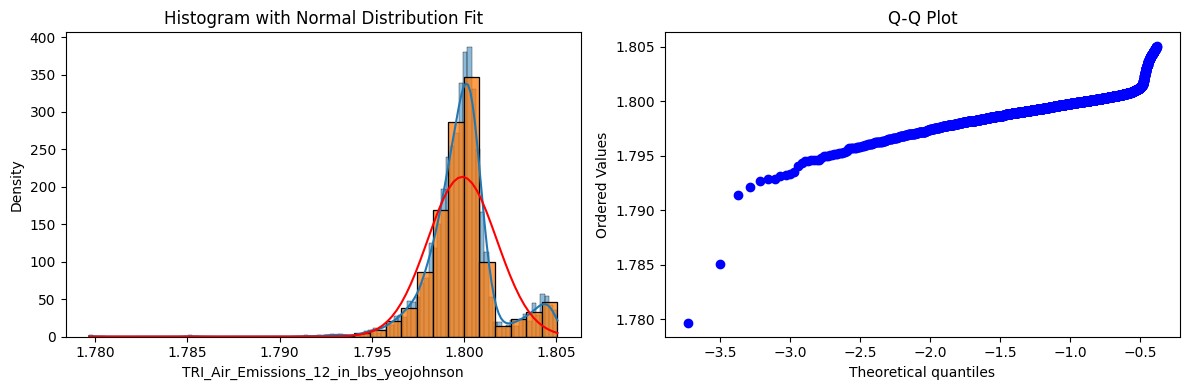

Skewness: -0.4448858211669812
Kurtosis: 8.316124758675606
isnull: 4654

lamda_y: -0.4712165464684104


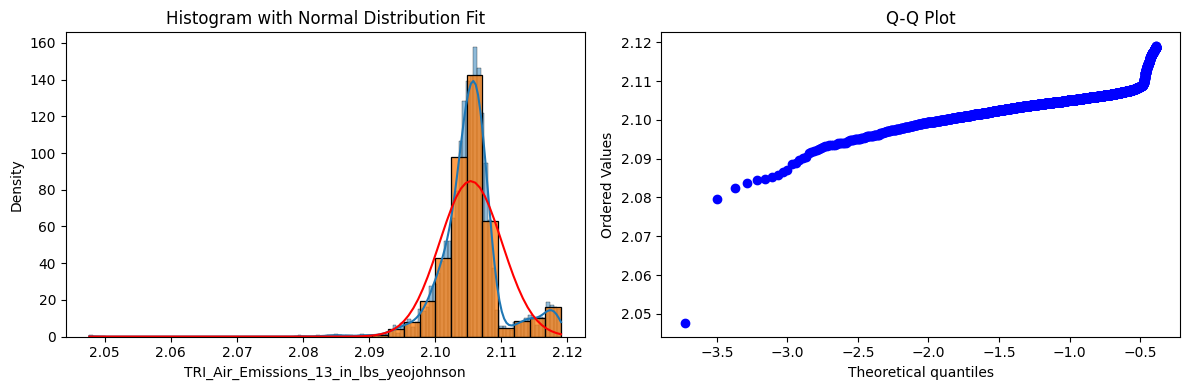

Skewness: -0.5530699569430443
Kurtosis: 11.335708005614322
isnull: 4654

lamda_y: -0.1362199856112669


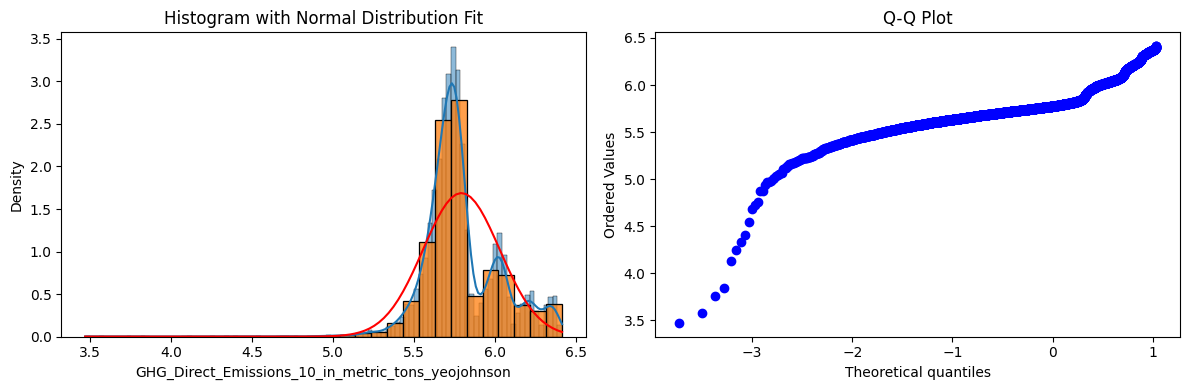

Skewness: -0.19781382598238792
Kurtosis: 5.97305304521441
isnull: 1080

lamda_y: -0.00048354524313931054


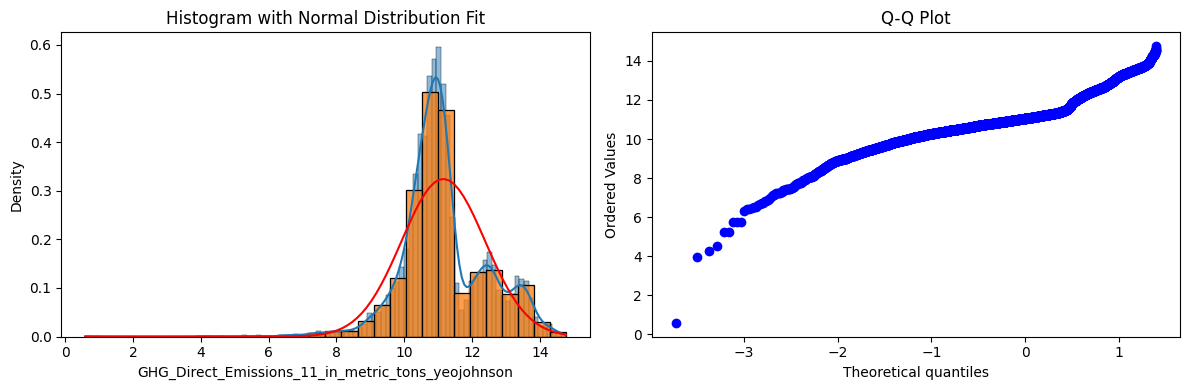

Skewness: -0.00040507398690345207
Kurtosis: 2.035841743145956
isnull: 582

lamda_y: -0.21287057480503097


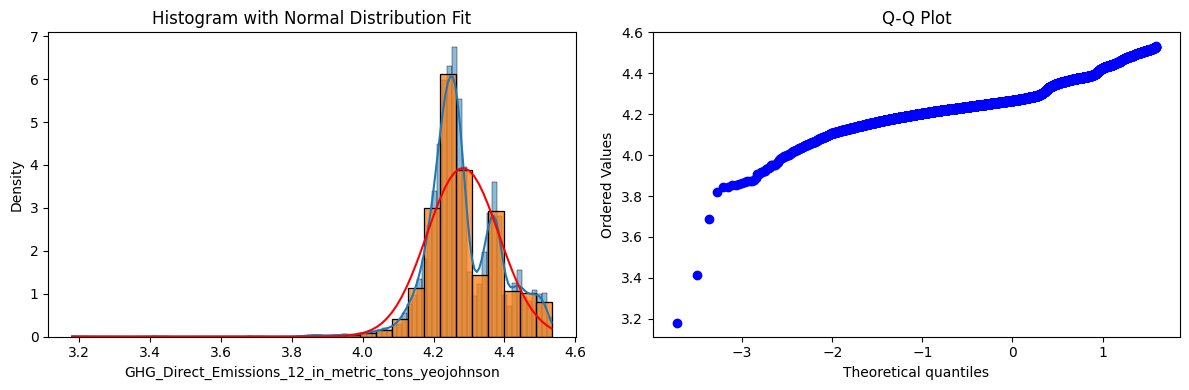

Skewness: -0.1342265330070124
Kurtosis: 3.452226959355852
isnull: 397

lamda_y: -0.06737476433771017


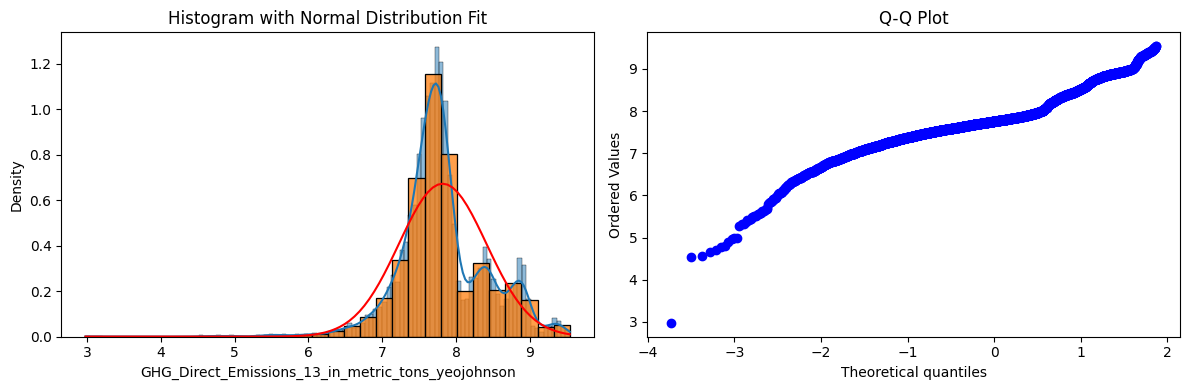

Skewness: -0.055411845567373205
Kurtosis: 2.3410125460306603
isnull: 221



In [71]:
for col in numerical_features:
    yeojohnson_transform(df, col)
    normal_distribution_fit(df, col + "_yeojohnson")
    print()

In [72]:
numerical_features_yeojohnson = [col + "_yeojohnson" for col in numerical_features]

In [73]:
numerical_features_yeojohnson

['TRI_Air_Emissions_10_in_lbs_yeojohnson',
 'TRI_Air_Emissions_11_in_lbs_yeojohnson',
 'TRI_Air_Emissions_12_in_lbs_yeojohnson',
 'TRI_Air_Emissions_13_in_lbs_yeojohnson',
 'GHG_Direct_Emissions_10_in_metric_tons_yeojohnson',
 'GHG_Direct_Emissions_11_in_metric_tons_yeojohnson',
 'GHG_Direct_Emissions_12_in_metric_tons_yeojohnson',
 'GHG_Direct_Emissions_13_in_metric_tons_yeojohnson']

In [74]:
# 平均変化率からの予測
df['TRI_average_rate_of_change'] = (df['TRI_Air_Emissions_13_in_lbs_yeojohnson'] / df['TRI_Air_Emissions_10_in_lbs_yeojohnson'])**(1/3) - 1
df['TRI_from_average_rate_of_change'] = df['TRI_Air_Emissions_13_in_lbs_yeojohnson'] * (1 + df['TRI_average_rate_of_change'])

In [75]:
tri_features = [
    'TRI_Air_Emissions_10_in_lbs_yeojohnson',
 'TRI_Air_Emissions_11_in_lbs_yeojohnson',
 'TRI_Air_Emissions_12_in_lbs_yeojohnson',
 'TRI_Air_Emissions_13_in_lbs_yeojohnson',
                'TRI_average_rate_of_change', 'TRI_from_average_rate_of_change']

In [76]:
# GHG排出量の特徴量

# 欠損値補完の処理（仮、kNN補間のほうがいいかも？）
# 'GHG_Direct_Emissions_10_in_metric_tons'の欠損値は'GHG_Direct_Emissions_11_in_metric_tons'で補完
df['GHG_10_fillna'] = df['GHG_Direct_Emissions_10_in_metric_tons_yeojohnson'].fillna(df['GHG_Direct_Emissions_11_in_metric_tons_yeojohnson'])

# 'GHG_Direct_Emissions_11_in_metric_tons'の欠損値は'GHG_Direct_Emissions_10_in_metric_tons'で補完
df['GHG_11_fillna'] = df['GHG_Direct_Emissions_11_in_metric_tons_yeojohnson'].fillna(df['GHG_Direct_Emissions_10_in_metric_tons_yeojohnson'])

# 'GHG_Direct_Emissions_12_in_metric_tons'の欠損値は'GHG_Direct_Emissions_11_in_metric_tons'で補完
df['GHG_12_fillna'] = df['GHG_Direct_Emissions_12_in_metric_tons_yeojohnson'].fillna(df['GHG_Direct_Emissions_11_in_metric_tons_yeojohnson'])

# 'GHG_Direct_Emissions_13_in_metric_tons'の欠損値は'GHG_Direct_Emissions_12_in_metric_tons'で補完
df['GHG_13_fillna'] = df['GHG_Direct_Emissions_13_in_metric_tons_yeojohnson'].fillna(df['GHG_Direct_Emissions_12_in_metric_tons_yeojohnson'])

# 平均（直近◯年）
df['GHG_mean_4years'] = df[['GHG_10_fillna', 'GHG_11_fillna', 'GHG_12_fillna', 'GHG_13_fillna']].mean(axis=1)
df['GHG_mean_3years'] = df[['GHG_11_fillna', 'GHG_12_fillna', 'GHG_13_fillna']].mean(axis=1)
df['GHG_mean_2years'] = df[['GHG_12_fillna', 'GHG_13_fillna']].mean(axis=1)


# 平均変化率からの予測
df['average_rate_of_change'] = (df['GHG_13_fillna'] / df['GHG_10_fillna'])**(1/3) - 1
df['GHG_from_average_rate_of_change'] = df['GHG_13_fillna'] * (1 + df['average_rate_of_change'])

# 各年の差から予測
df['GHG_diff_13_12'] = df['GHG_13_fillna'] - df['GHG_12_fillna']
df['GHG_diff_12_11'] = df['GHG_12_fillna'] - df['GHG_11_fillna']
df['GHG_diff_11_10'] = df['GHG_11_fillna'] - df['GHG_10_fillna']

df['GHG_from_diff_pastyear'] = df['GHG_13_fillna'] + df['GHG_diff_13_12']
df['GHG_from_diff_2years'] = df['GHG_13_fillna'] + df['GHG_diff_12_11']

In [77]:
df.columns

Index(['FacilityName', 'Latitude', 'Longitude', 'LocationAddress', 'City',
       'State', 'ZIP', 'County', 'FIPScode', 'PrimaryNAICS',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons_log1p', 'is_train', 'Chemicals',
       'Coal-based Liquid Fuel Supply',
       'Import and Export of Equipment Containing Fluorintaed GHGs',
       'Industrial Gas Suppliers', 'Injection of CO2', 'Metals', 'Minerals',
       'Natural Gas and Natural Gas Liquids Suppliers', 'Other',
       'Petroleum Product Suppliers', 'Petroleum and Natural Gas Systems',
       'Power Plants', 'Pulp and Pape

In [78]:
def grouping_calculation(df, features_colc, group_col):
    for col in features_colc:
        # ジャンルごとの平均値と標準偏差を計算
        group_stats = df.groupby(group_col)[col].agg(['min', 'max', 'mean', 'std']).reset_index()
        group_stats.rename(columns={'min': col+'_min_'+group_col, 'max': col+'_max_'+group_col, 'mean': col+'_mean_'+group_col, 'std': col+'_std_'+group_col}, inplace=True)

        # 元のデータフレームにマージ
        df = pd.merge(df, group_stats, on=group_col, how='left')

        # 最小、最大、平均値との差の絶対値を計算
        df[col+'_diff_mean'] = abs(df[col] - df[col+'_mean_'+group_col])
        df[col+'_diff_min'] = abs(df[col] - df[col+'_min_'+group_col])
        df[col+'_diff_max'] = abs(df[col] - df[col+'_max_'+group_col])


        # 標準化を計算
        df[col+'_z'] = (df[col] - df[col+'_mean_'+group_col]) / df[col+'_std_'+group_col]

        # q1とq3を計算
        group_qstats = df.groupby(group_col)[col].agg([
            ('Q1', lambda x: x.quantile(0.25)),  # 第1四分位数
            ('Q3', lambda x: x.quantile(0.75))   # 第3四分位数
        ]).reset_index()

        # 四分位範囲 (IQR) を計算
        group_qstats['IQR'] = group_qstats['Q3'] - group_qstats['Q1']
        group_qstats.rename(columns={'Q1': col+'_q1_'+group_col, 'Q3': col+'_q3_'+group_col, 'IQR': col+'_iqr_'+group_col}, inplace=True)

        # 元のデータフレームにマージ
        df = pd.merge(df, group_qstats, on=group_col, how='left')

    return df

features_colc = ['GHG_10_fillna', 'GHG_11_fillna', 'GHG_12_fillna', 'GHG_13_fillna']
group_col = 'PrimaryNAICS_1-2'
df = grouping_calculation(df, features_colc, group_col)
df.columns.tolist()

['FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons_log1p',
 'is_train',
 'Chemicals',
 'Coal-based Liquid Fuel Supply',
 'Import and Export of Equipment Containing Fluorintaed GHGs',
 'Industrial Gas Suppliers',
 'Injection of CO2',
 'Metals',
 'Minerals',
 'Natural Gas and Natural Gas Liquids Suppliers',
 'Other',
 'Petroleum Product Suppliers',
 'Petroleum and Natural Gas Systems',
 'Power Plants',
 'Pulp and Paper',
 'Refineries',
 'Suppliers of CO2',
 'Waste',
 'PrimaryNAICS_1-2',
 'Pri

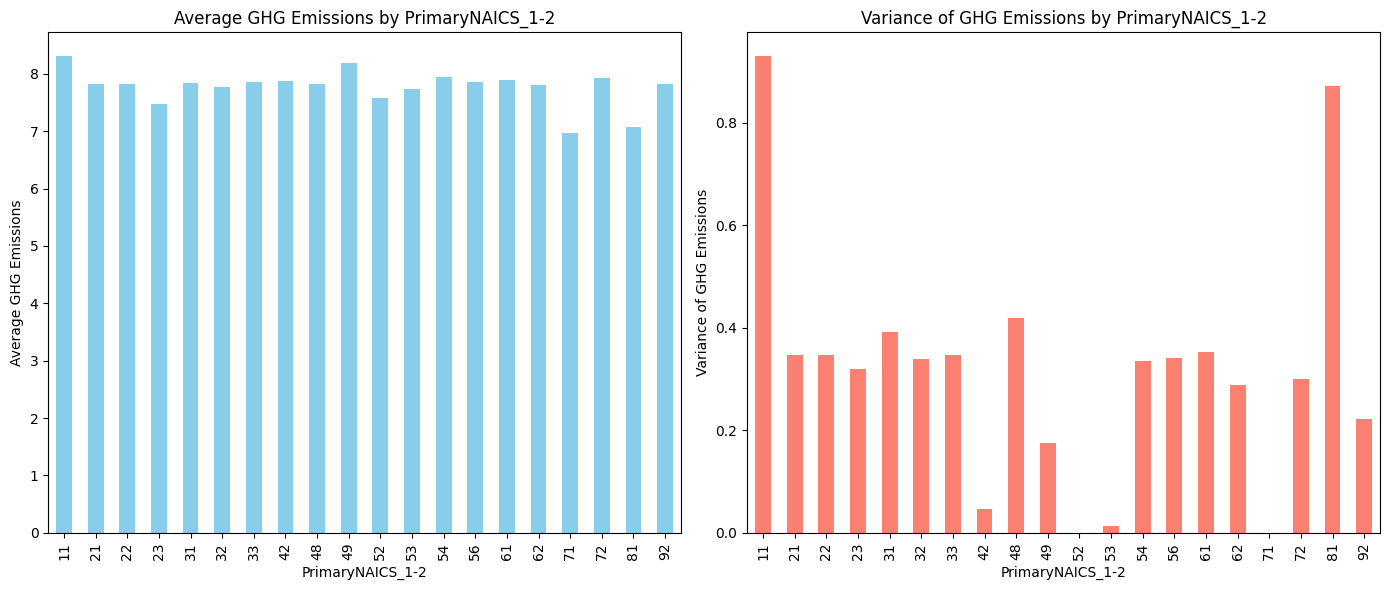

In [79]:
# GHG_Direct_Emissions_13_in_metric_tonsの平均と分散を'PrimaryNAICS_1-2'ごとに計算
grouped = df.groupby('PrimaryNAICS_1-2')['GHG_13_fillna'].agg(['mean', 'var'])

# グラフの設定
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 平均のプロット
grouped['mean'].plot(kind='bar', ax=ax[0], color='skyblue', title='Average GHG Emissions by PrimaryNAICS_1-2')
ax[0].set_ylabel('Average GHG Emissions')

# 分散のプロット
grouped['var'].plot(kind='bar', ax=ax[1], color='salmon', title='Variance of GHG Emissions by PrimaryNAICS_1-2')
ax[1].set_ylabel('Variance of GHG Emissions')

plt.tight_layout()
plt.show()

In [80]:
df['GHG_TRI_rate_14'] = df['GHG_from_average_rate_of_change'] / df['TRI_from_average_rate_of_change']
df['GHG_TRI_rate_13'] = df['GHG_13_fillna'] / df['TRI_Air_Emissions_13_in_lbs_yeojohnson']
df['GHG_TRI_rate_12'] = df['GHG_12_fillna'] / df['TRI_Air_Emissions_12_in_lbs_yeojohnson']
df['GHG_TRI_rate_11'] = df['GHG_11_fillna'] / df['TRI_Air_Emissions_11_in_lbs_yeojohnson']
df['GHG_TRI_rate_10'] = df['GHG_10_fillna'] / df['TRI_Air_Emissions_10_in_lbs_yeojohnson']

In [81]:
# def calculate_distance(lat1, lon1, lat2, lon2): #ハーバサインの公式 を用いて、2つの座標間の地球表面の距離を計算
#     # Convert latitude and longitude from degrees to radians
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

#     # Haversine formula
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

#     # Radius of Earth in kilometers (mean radius)
#     R = 6371.0

#     # Calculate the distance
#     distance = R * c
#     return distance

In [82]:
# def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
#     # Extract the required columns once to NumPy arrays
#     latitudes = df_train['Latitude'].values
#     longitudes = df_train['Longitude'].values
#     ghg_emissions = df_train['GHG_Direct_Emissions_14_in_metric_tons'].values
#     econ_sectors = df_train['PrimaryNAICS_1-2'].values

#     # Filter NaN emissions directly
#     valid_indices = ~np.isnan(ghg_emissions)

#     latitudes = latitudes[valid_indices]
#     longitudes = longitudes[valid_indices]
#     ghg_emissions = ghg_emissions[valid_indices]
#     econ_sectors = econ_sectors[valid_indices]

#     # Parallelize distance calculation using ThreadPoolExecutor
#     with ThreadPoolExecutor() as executor:
#         distances = list(executor.map(calculate_distance,
#                                      [lat1]*len(latitudes),
#                                      [lon1]*len(longitudes),
#                                      latitudes,
#                                      longitudes))

#     # Combine the results into a DataFrame
#     near_df = pd.DataFrame({
#         'Distance': distances,
#         'GHG_emission_14': ghg_emissions,
#         'Economic_Sector': econ_sectors
#     })


#     if train_point:
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()
#         near_df = near_df.iloc[1:].reset_index(drop=True)
#     else:
#         # Sort distances by 'Distance'
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()

#     # Filter by economic sector
#     nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

#     # Get the top N nearest for both economic sector and overall
#     sub_near_econ = nearest_locations_econ_sector.head(neighbours)
#     sub_nearest_locations = near_df.head(neighbours)

#     # Compute weighted averages
#     econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
#     near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

#     # Compute regular averages
#     econ_average = sub_near_econ['GHG_emission_14'].mean()
#     near_average = sub_nearest_locations['GHG_emission_14'].mean()

#     return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [83]:
# df_train, df_test = split_train_test(df)

In [84]:
# import os
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor
# import math

# neighbours = 5

# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     test_distance = pd.read_csv(f"test_distance_{neighbours}nbrs.csv")
# else:
#     output = []
#     for index in tqdm(range(df.shape[0])):

#         lat1 = df_test.iloc[index]['Latitude']
#         lon1 = df_test.iloc[index]['Longitude']
#         econ_sector_ref = df_test.iloc[index]['IndustryGroup_str']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours,train_point=False)
#         output.append(x)

#     test_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])

#     test_distance.to_csv(f'test_distance_{neighbours}nbrs.csv',index=False)


# file_path = f"train_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     train_distance = pd.read_csv(f'train_distance_{neighbours}nbrs.csv')
# else:
#     output = []
#     for index in tqdm(range(df.shape[0])):
#         lat1 = df_train.iloc[index]['Latitude']
#         lon1 = df_train.iloc[index]['Longitude']
#         econ_sector_ref = df_train.iloc[index]['IndustryGroup_str']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours, train_point=True)
#         output.append(x)

#     train_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     train_distance.to_csv(f'train_distance_{neighbours}nbrs.csv',index=False)



# df_train = pd.concat((df_train,train_distance),axis=1)
# df_test  = pd.concat((df_test,test_distance),axis=1)

In [85]:
train_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/train_distance_5nbrs_.csv')
test_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/test_distance_5nbrs_.csv')

df_train, df_test = split_train_test(df)
df_train = pd.concat((df_train,train_distance),axis=1)
df_test  = pd.concat((df_test,test_distance),axis=1)

In [86]:
df_train.columns.tolist()

['FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons_log1p',
 'is_train',
 'Chemicals',
 'Coal-based Liquid Fuel Supply',
 'Import and Export of Equipment Containing Fluorintaed GHGs',
 'Industrial Gas Suppliers',
 'Injection of CO2',
 'Metals',
 'Minerals',
 'Natural Gas and Natural Gas Liquids Suppliers',
 'Other',
 'Petroleum Product Suppliers',
 'Petroleum and Natural Gas Systems',
 'Power Plants',
 'Pulp and Paper',
 'Refineries',
 'Suppliers of CO2',
 'Waste',
 'PrimaryNAICS_1-2',
 'Pri

In [95]:
ghg_features = ['GHG_10_fillna',
       'GHG_11_fillna', 'GHG_12_fillna', 'GHG_13_fillna', 'GHG_mean_4years',
       'GHG_mean_3years', 'GHG_mean_2years', 'average_rate_of_change',
       'GHG_from_average_rate_of_change', 'GHG_diff_13_12', 'GHG_diff_12_11',
       'GHG_diff_11_10', 'GHG_from_diff_pastyear', 'GHG_from_diff_2years',
#  'GHG_10_fillna_mean_PrimaryNAICS_1-2',
#  'GHG_10_fillna_std_PrimaryNAICS_1-2',
 'GHG_10_fillna_diff_mean',
 'GHG_10_fillna_diff_min',
 'GHG_10_fillna_diff_max',
 'GHG_10_fillna_z',
#  'GHG_11_fillna_mean_PrimaryNAICS_1-2',
#  'GHG_11_fillna_std_PrimaryNAICS_1-2',
 'GHG_11_fillna_diff_mean',
 'GHG_11_fillna_diff_min',
 'GHG_11_fillna_diff_max',
 'GHG_11_fillna_z',
#  'GHG_12_fillna_mean_PrimaryNAICS_1-2',
#  'GHG_12_fillna_std_PrimaryNAICS_1-2',
 'GHG_12_fillna_diff_mean',
 'GHG_12_fillna_diff_min',
 'GHG_12_fillna_diff_max',
 'GHG_12_fillna_z',
#  'GHG_13_fillna_mean_PrimaryNAICS_1-2',
#  'GHG_13_fillna_std_PrimaryNAICS_1-2',
 'GHG_13_fillna_diff_mean',
 'GHG_13_fillna_diff_min',
 'GHG_13_fillna_diff_max',
 'GHG_13_fillna_z',
# 'GHG_TRI_rate_14',
#  'GHG_TRI_rate_13',
#  'GHG_TRI_rate_12',
#  'GHG_TRI_rate_11',
#  'GHG_TRI_rate_10',
                'Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average']

# 予測モデルの学習・検証


In [88]:
# df_train, df_test = split_train_test(df)

In [96]:
categorical_features = []
features = tri_features + ghg_features + location_features
# industry_feature categorical_features
features

['TRI_Air_Emissions_10_in_lbs_yeojohnson',
 'TRI_Air_Emissions_11_in_lbs_yeojohnson',
 'TRI_Air_Emissions_12_in_lbs_yeojohnson',
 'TRI_Air_Emissions_13_in_lbs_yeojohnson',
 'TRI_average_rate_of_change',
 'TRI_from_average_rate_of_change',
 'GHG_10_fillna',
 'GHG_11_fillna',
 'GHG_12_fillna',
 'GHG_13_fillna',
 'GHG_mean_4years',
 'GHG_mean_3years',
 'GHG_mean_2years',
 'average_rate_of_change',
 'GHG_from_average_rate_of_change',
 'GHG_diff_13_12',
 'GHG_diff_12_11',
 'GHG_diff_11_10',
 'GHG_from_diff_pastyear',
 'GHG_from_diff_2years',
 'GHG_10_fillna_diff_mean',
 'GHG_10_fillna_diff_min',
 'GHG_10_fillna_diff_max',
 'GHG_10_fillna_z',
 'GHG_11_fillna_diff_mean',
 'GHG_11_fillna_diff_min',
 'GHG_11_fillna_diff_max',
 'GHG_11_fillna_z',
 'GHG_12_fillna_diff_mean',
 'GHG_12_fillna_diff_min',
 'GHG_12_fillna_diff_max',
 'GHG_12_fillna_z',
 'GHG_13_fillna_diff_mean',
 'GHG_13_fillna_diff_min',
 'GHG_13_fillna_diff_max',
 'GHG_13_fillna_z',
 'Economy_Sector_Weighted_Avg',
 'Economic_Sector

In [90]:
# def plot_heatmap(df):
#     # 数値データのみを抽出
#     numeric_df = df.select_dtypes(include=['number'])

#     # 相関行列を計算
#     correlation_matrix = numeric_df.corr()

#     # ヒートマップを描画
#     plt.figure(figsize=(12, 10))  # サイズを大きくする
#     sns.heatmap(
#         correlation_matrix,
#         annot=True,
#         fmt='.2f',
#         cmap=sns.diverging_palette(240, 10, as_cmap=True),  # 青から赤のカラーマップ
#         center=0,  # 中心を0に設定
#         square=True,
#         cbar_kws={"shrink": .8},
#         annot_kws={"size": 10}  # アノテーションのフォントサイズを設定
#     )
#     plt.title('Heatmap of Correlation Matrix', fontsize=12)  # タイトルのフォントサイズを設定
#     plt.show()

# df_train = df_train[features + ['GHG_Direct_Emissions_14_in_metric_tons']]
# plot_heatmap(df_train)

In [97]:
# 訓練用データセットからターゲットを分離する
df_train = df_train[features]
target = train['GHG_Direct_Emissions_14_in_metric_tons']

# 投稿のためのテストデータも同様の処理を行う
df_test = df_test[features]

------------------------------ fold 0 ------------------------------
Fold 0 Tr RMSLE score: 0.73848
Fold 0 Va RMSLE score: 0.67805

------------------------------ fold 1 ------------------------------
Fold 1 Tr RMSLE score: 0.72664
Fold 1 Va RMSLE score: 0.78438

------------------------------ fold 2 ------------------------------
Fold 2 Tr RMSLE score: 0.72999
Fold 2 Va RMSLE score: 0.76039

------------------------------ fold 3 ------------------------------
Fold 3 Tr RMSLE score: 0.73633
Fold 3 Va RMSLE score: 0.68344

------------------------------ fold 4 ------------------------------
Fold 4 Tr RMSLE score: 0.72915
Fold 4 Va RMSLE score: 0.76328

------------------------------ fold 5 ------------------------------
Fold 5 Tr RMSLE score: 0.72824
Fold 5 Va RMSLE score: 0.77607

------------------------------ fold 6 ------------------------------
Fold 6 Tr RMSLE score: 0.73439
Fold 6 Va RMSLE score: 0.74127

------------------------------ fold 7 ------------------------------
Fold 7 

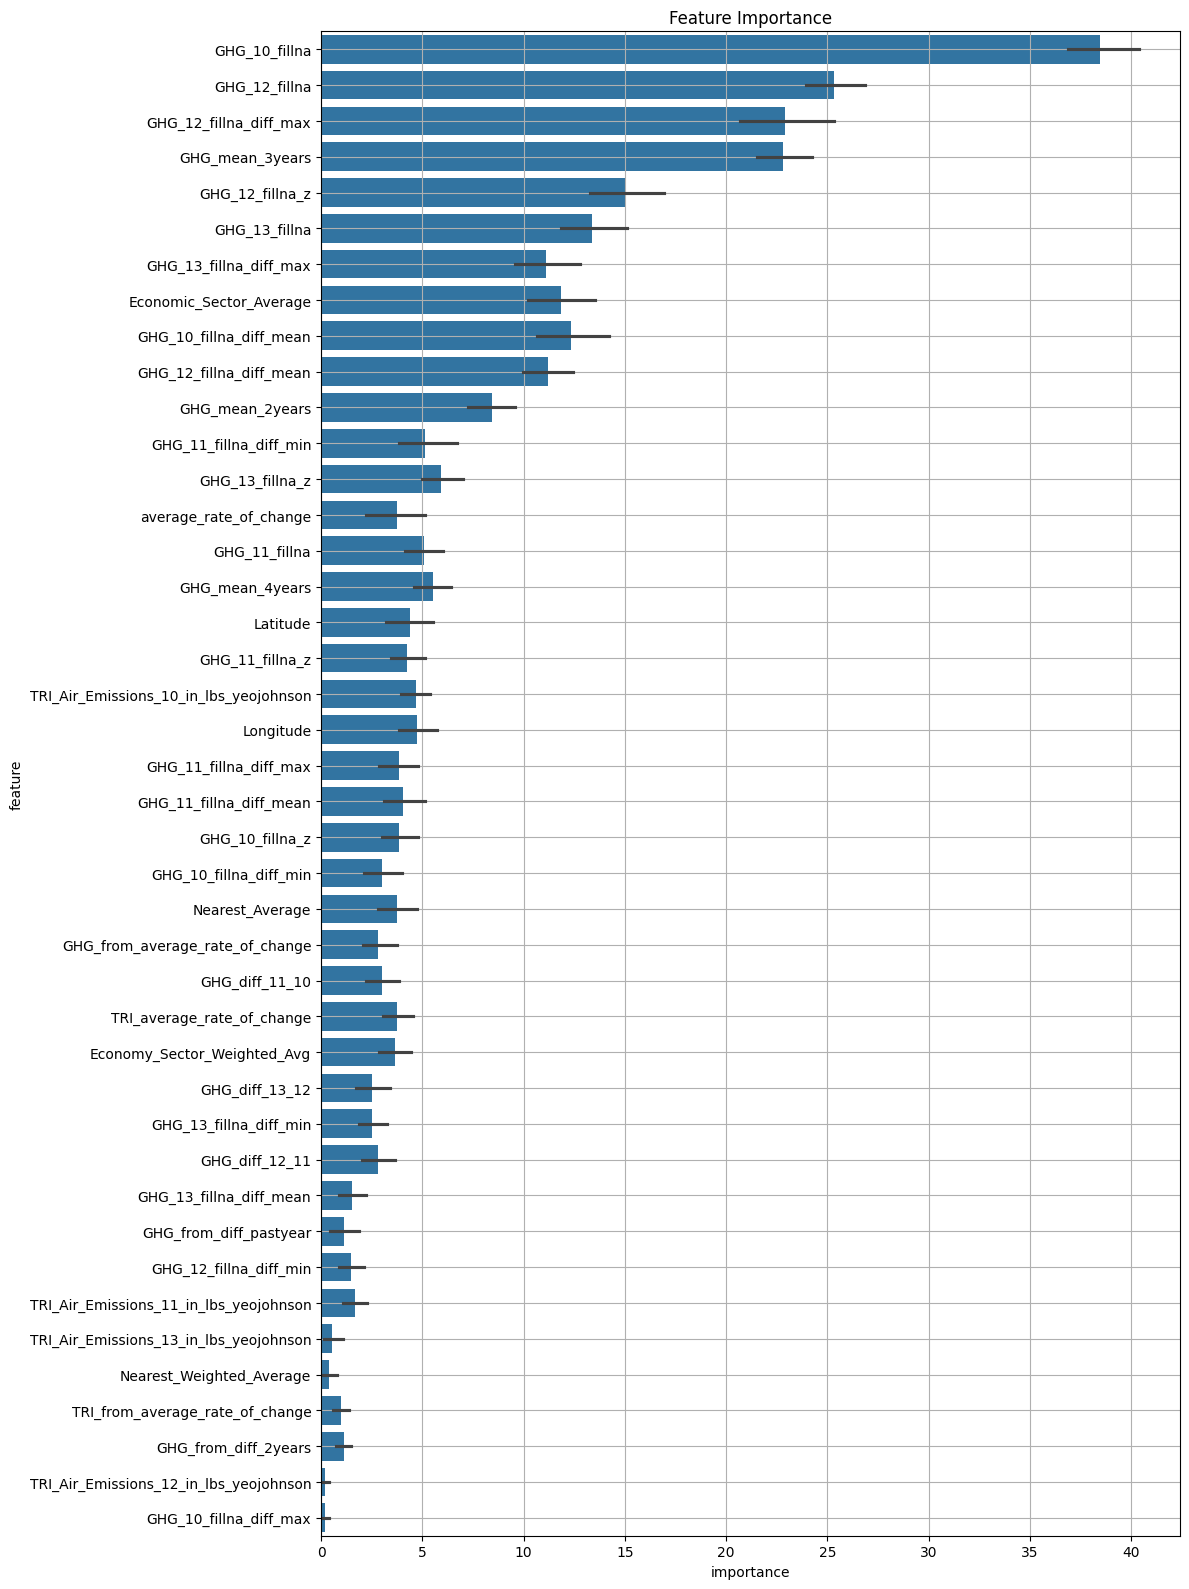

In [159]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
df_feature_importance = pd.DataFrame()

fold_rmsle_scores = []
train_rmsle_scores = []
# train_score_variance = []

# foldに分けて学習と評価を行う
for fold_, (indexes_trn, indexes_val) in enumerate(kf.split(df_train.values)):  # 変更: target.valuesは不要
    print(f"------------------------------ fold {fold_} ------------------------------")

    target_log1p = np.log1p(target)

    # 学習データと評価データを元の学習データから抽出
    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    target_trn = target_log1p.loc[indexes_trn].reset_index(drop=True)

    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_val = target_log1p.loc[indexes_val].reset_index(drop=True)

    # lightGBMモデル用のデータセット
    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=categorical_features
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=categorical_features
    )

    # モデルパラメータ設定
    lgb_params = {
        'objective': 'regression',  # 回帰タスク
        'metric': 'rmse',  # RMSEで評価
        'boosting_type': 'gbdt',  # 勾配ブースティング木
        'learning_rate': 0.1,  # 学習率
        'verbose': -1,  # 詳細な出力を抑制
        'random_state': 42,  # 乱数の固定
        'lambda_l1': 0.5,  # L1正則項の強さ
        'lambda_l2': 50,  # L2正則項の強さ
        'max_depth': 3,  # 木の最大深さ
        "min_data_in_leaf": 50,
        'num_leaves': 8,  # 最大リーフ数
        'max_bin' : 100,
        "n_estimators": 50
    }



    # モデル学習の最大回数
    num_round = 999999999

    # モデル作成
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_round,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)],
    )

    # 最適な学習回数を設定
    prediction_round = model.best_iteration

    # 最適な学習回数に基づいて予測
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    # Trainデータでの予測とRMSLEを計算
    oof_train = model.predict(df_trn[features], num_iteration=prediction_round)
    oof_train_min = oof_train.min()
    if oof_train_min < 0:
        oof_train = oof_train + abs(oof_train_min) + 1  # 予測結果にオフセットを加える

    try:
        # 逆対数変換後にRMSLEを計算
        oof_train_inv = np.expm1(oof_train)  # 逆対数変換
        target_trn_inv = np.expm1(target_trn)  # 逆対数変換
        train_rmsle_score = mean_squared_log_error(target_trn_inv, oof_train_inv, squared=False)
        train_rmsle_scores.append(train_rmsle_score)
        # train_score_variance = np.var(train_rmsle_scores)
        print(f"Fold {fold_} Tr RMSLE score: {train_rmsle_score:.5f}")
    except ValueError:
        print(f"Fold {fold_} encountered an error with Train RMSLE (possibly negative values).")
        continue

    # valデータでの予測とRMSLEを計算
    oof_min = oof[indexes_val].min()
    if oof_min < 0:
        offset = abs(oof_min) + 1  # ゼロまたは負の値を含まないように調整
        oof[indexes_val] = oof[indexes_val] + offset  # 予測結果にオフセットを加える

    # 逆対数変換後にRMSLEを計算
    try:
        oof_inv = np.expm1(oof[indexes_val])  # 逆対数変換
        target_val_inv = np.expm1(target_val)  # 逆対数変換
        rmsle_score = mean_squared_log_error(target_val_inv, oof_inv, squared=False)
        fold_rmsle_scores.append(rmsle_score)
        # val_score_variance = np.var(fold_rmsle_scores)
        print(f"Fold {fold_} Va RMSLE score: {rmsle_score:.5f}")
    except ValueError:
        print(f"Fold {fold_} encountered an error with RMSLE (possibly negative values).")
        continue

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()


# 各foldのTrainデータに対するRMSLEスコアを表示
print("\nFold-wise Tr RMSLE scores:")
for i, train_rmsle in enumerate(train_rmsle_scores):
    print(f"  Fold {i}: {train_rmsle:.5f}")

# 各foldのRMSLEスコアを表示
print("\nFold-wise Va RMSLE scores:")
for i, rmsle in enumerate(fold_rmsle_scores):
    print(f"  Fold {i}: {rmsle:.5f}")

# 全体の分散を計算
overall_train_variance = np.var(train_rmsle_scores)
overall_val_variance = np.var(fold_rmsle_scores)

# 最終的なRMSLEスコア（全体）
oof_train_inv = np.expm1(oof_train)  # 逆対数変換
target_trn_inv = np.expm1(target_trn)  # 逆対数変換
train_score = mean_squared_log_error(target_trn_inv, oof_train_inv, squared=False)

oof_inv = np.expm1(oof[indexes_val])  # 逆対数変換
target_val_inv = np.expm1(target_val)  # 逆対数変換
score = mean_squared_log_error(target_val_inv, oof_inv, squared=False)

print()
print(f"[CV] tr: {train_score:8.5f} ± {overall_train_variance:.5f} va: {score:8.5f} ± {overall_val_variance:.5f}")

# Feature importanceの可視化
plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.grid()
plt.tight_layout()
plt.show()

# 予測・結果の投稿

In [160]:
# testデータに対する予測
test_pred = model.predict(df_test, num_iteration=prediction_round)

# 予測結果に逆対数変換を適用
test_pred_inv = np.expm1(test_pred)  # 逆対数変換
test_pred_inv

array([  44352.79274241,  331263.73345454,   38931.12481743, ...,
        139778.38555974,  285728.44024915, 1210333.31488932])

In [161]:
# 投稿ファイル作成
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_pred_inv

submit.to_csv('submit_ghg11.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,44352.792742
1,4656,331263.733455
2,4657,38931.124817
3,4658,28700.707493
4,4659,39278.101751
